# Battery Degradation Analysis of NASA Li-On Batteries - Discharge

This data-set was cleaned and pre-processed to a certain extent on the Kaggle website. The analysis below intends to pick up further from the cleaned data to conduct further cleaning and exploratory data analysis.

## Load MetaData

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import os
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score

data_folder = './data'
meta_data = pd.read_csv(os.path.join(data_folder, "metadata_files/updated_metadata.csv"))

In [23]:
meta_data

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct,...,std_Current_load,std_Current_measured,std_Rectified_Impedance,std_Sense_current,std_Temperature_measured,std_Voltage_charge,std_Voltage_load,std_Voltage_measured,Impedance_Magnitude_Avg,Impedance_Magnitude_Change_Rate
0,charge,2008-04-02 13:08:17,24,B0005,0,5121,05121.csv,NaN,NaN,NaN,...,NaN,0.625804,NaN,NaN,1.011951,0.881125,NaN,0.045794,NaN,NaN
1,discharge,2008-04-02 15:25:41,24,B0005,1,5122,05122.csv,1.8564874208181574,NaN,NaN,...,0.591217,0.595058,NaN,NaN,3.495804,NaN,0.796974,0.236558,NaN,NaN
2,charge,2008-04-02 16:37:51,24,B0005,2,5123,05123.csv,NaN,NaN,NaN,...,NaN,0.666615,NaN,NaN,1.358494,0.710712,NaN,0.177474,NaN,NaN
3,discharge,2008-04-02 19:43:48,24,B0005,3,5124,05124.csv,1.846327249719927,NaN,NaN,...,0.592561,0.596704,NaN,NaN,3.435509,NaN,0.796596,0.235366,NaN,NaN
4,charge,2008-04-02 20:55:40,24,B0005,4,5125,05125.csv,NaN,NaN,NaN,...,NaN,0.667309,NaN,NaN,1.371851,0.808036,NaN,0.175380,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7560,impedance,2010-09-30 07:36:45,24,B0056,247,7309,07309.csv,NaN,0.10267706871685421,0.17039406000537094,...,NaN,NaN,0.02221,28.396201,NaN,NaN,NaN,NaN,0.131623,NaN
7561,discharge,2010-09-30 08:08:36,4,B0056,248,7310,07310.csv,1.1372731775310292,NaN,NaN,...,0.641559,0.640077,NaN,NaN,1.998990,NaN,0.757044,0.277913,NaN,NaN
7562,charge,2010-09-30 08:48:54,4,B0056,249,7311,07311.csv,NaN,NaN,NaN,...,NaN,0.466150,NaN,NaN,1.155468,0.262042,NaN,0.030122,NaN,NaN
7563,discharge,2010-09-30 11:50:17,4,B0056,250,7312,07312.csv,1.1290590137779504,NaN,NaN,...,0.686409,0.684880,NaN,NaN,2.170885,NaN,0.808908,0.291255,NaN,NaN


In [24]:
actual_data = pd.read_csv(os.path.join(data_folder, "csv_files/00001.csv"))
actual_data

,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Time
0,4.246711,0.000252,6.212696,0.0002,0.000,0.000
1,4.246764,-0.001411,6.234019,0.0002,4.262,9.360
2,4.039277,-0.995093,6.250255,1.0000,3.465,23.281
3,4.019506,-0.996731,6.302176,1.0000,3.451,36.406
4,4.004763,-0.992845,6.361645,1.0000,3.438,49.625
...,...,...,...,...,...,...
485,3.303251,-0.001760,9.662331,0.0004,0.000,6382.063
486,3.310303,-0.000756,9.390489,0.0002,0.000,6395.547
487,3.317351,-0.003318,9.137008,0.0002,0.000,6409.063
488,3.323387,-0.002291,8.972806,0.0002,0.000,6422.625


## Clean the data

In [25]:
data = './data/csv_files'
data_files = os.listdir(data)

## Feature Engineering

In [26]:
discharge_data = meta_data[meta_data['type'] == 'discharge']
discharge_data

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct,...,std_Current_load,std_Current_measured,std_Rectified_Impedance,std_Sense_current,std_Temperature_measured,std_Voltage_charge,std_Voltage_load,std_Voltage_measured,Impedance_Magnitude_Avg,Impedance_Magnitude_Change_Rate
1,discharge,2008-04-02 15:25:41,24,B0005,1,5122,05122.csv,1.8564874208181574,NaN,NaN,...,0.591217,0.595058,NaN,NaN,3.495804,NaN,0.796974,0.236558,NaN,NaN
3,discharge,2008-04-02 19:43:48,24,B0005,3,5124,05124.csv,1.846327249719927,NaN,NaN,...,0.592561,0.596704,NaN,NaN,3.435509,NaN,0.796596,0.235366,NaN,NaN
5,discharge,2008-04-03 00:01:06,24,B0005,5,5126,05126.csv,1.8353491942234077,NaN,NaN,...,0.593925,0.598033,NaN,NaN,3.388174,NaN,0.797389,0.228111,NaN,NaN
7,discharge,2008-04-03 04:16:37,24,B0005,7,5128,05128.csv,1.8352625275821128,NaN,NaN,...,0.581063,0.584972,NaN,NaN,3.395306,NaN,0.780677,0.233347,NaN,NaN
9,discharge,2008-04-03 08:33:25,24,B0005,9,5130,05130.csv,1.8346455082120419,NaN,NaN,...,0.581067,0.584978,NaN,NaN,3.404667,NaN,0.781348,0.237301,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7553,discharge,2010-09-29 19:50:59,4,B0056,240,7302,07302.csv,1.1302191455340138,NaN,NaN,...,0.673089,0.671846,NaN,NaN,1.930534,NaN,0.794884,0.274334,NaN,NaN
7555,discharge,2010-09-29 23:33:00,4,B0056,242,7304,07304.csv,1.1258719408034097,NaN,NaN,...,0.694620,0.693156,NaN,NaN,2.199819,NaN,0.817954,0.288791,NaN,NaN
7557,discharge,2010-09-30 03:15:20,4,B0056,244,7306,07306.csv,1.1430108283920968,NaN,NaN,...,0.626521,0.625156,NaN,NaN,2.093572,NaN,0.743539,0.281482,NaN,NaN
7561,discharge,2010-09-30 08:08:36,4,B0056,248,7310,07310.csv,1.1372731775310292,NaN,NaN,...,0.641559,0.640077,NaN,NaN,1.998990,NaN,0.757044,0.277913,NaN,NaN


In [27]:
discharge_files = discharge_data['filename'].values


def concat_files(files,data_folder):
    random_number_generator = np.random.RandomState(0)
    selected_dfs = []
    for file in tqdm(files):
        df = pd.read_csv(os.path.join(data_folder, "data", file))
        row = random_number_generator.randint(len(df)//2, len(df))
        time = df.iloc[row]['Time']
        rul = df.iloc[-1]['Time'] - time

        agg_features = ['mean','std']
        aggs = df.iloc[:row].agg(agg_features).to_dict()
        features = df.iloc[row].to_dict()
        features['id'] = f"{file.split('.')[0]}"
        features['RUL'] = rul
        for k, v in aggs.items():
            if k == "Time":
                continue   
            for kk, vv in v.items():
                features[f"{k}_{kk}"] = vv
        selected_dfs.append(pd.DataFrame([features]))

    df = pd.concat(selected_dfs)
    print(f'Number of rows: {len(df)}')
    df = df.dropna()
    print(f'Number of rows after dropping nan: {len(df)}')

    return df

discharge_df = concat_files(discharge_files,data_folder)

100%|██████████| 2794/2794 [00:31<00:00, 87.35it/s] 


Number of rows: 2794
Number of rows after dropping nan: 2794


In [29]:
discharge_df

,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Time,id,RUL,Voltage_measured_mean,Voltage_measured_std,Current_measured_mean,Current_measured_std,Temperature_measured_mean,Temperature_measured_std,Current_load_mean,Current_load_std,Voltage_load_mean,Voltage_load_std
0,3.433671,-2.013890,35.039044,-1.9982,2.516,2627.953,05122,1062.281,3.638897,0.152664,-1.984398,0.237642,31.016273,2.769170,-1.970100,0.236234,2.704155,0.293996
0,3.431758,-2.011369,35.431590,-1.9982,2.504,2686.735,05124,985.609,3.639661,0.153749,-1.984911,0.235508,31.294230,2.752163,-1.970674,0.233793,2.692593,0.291320
0,3.351767,-2.013560,36.624796,-1.9982,2.422,2996.297,05126,655.344,3.617328,0.162804,-1.987468,0.223405,31.721052,2.947709,-1.973404,0.221949,2.667950,0.284356
0,3.314541,-2.014007,36.777218,-1.9982,2.386,3055.282,05128,576.281,3.613360,0.166107,-1.987669,0.221392,31.685782,2.985660,-1.973848,0.219921,2.662006,0.284035
0,3.313635,-2.014596,36.648991,-1.9984,2.386,3053.250,05130,575.922,3.613863,0.166264,-1.988260,0.221250,31.547648,2.989190,-1.973860,0.219923,2.662970,0.284237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,3.269582,-1.995958,11.045818,1.9982,2.217,1231.171,07302,1113.829,3.480692,0.176166,-1.952131,0.284977,8.640700,1.401973,1.957025,0.285372,2.403237,0.336010
0,3.724337,-0.002238,11.200237,0.0006,0.000,2310.422,07304,52.625,3.343531,0.285923,-1.761987,0.640225,10.316107,2.227749,1.766436,0.641558,2.001823,0.761126
0,3.707628,0.000660,9.858506,0.0006,0.000,2224.547,07306,92.140,3.324460,0.275882,-1.855950,0.506500,10.298162,2.138908,1.860454,0.507672,2.107339,0.618130
0,2.955900,-1.994648,13.372730,1.9982,1.895,1850.843,07310,471.157,3.365137,0.219157,-1.965487,0.234119,9.836678,1.937341,1.970478,0.234621,2.287861,0.315224


# Exploratory Data Analysis - Charge Cycle

# Exploratory Data Analysis - Discharge Cycle

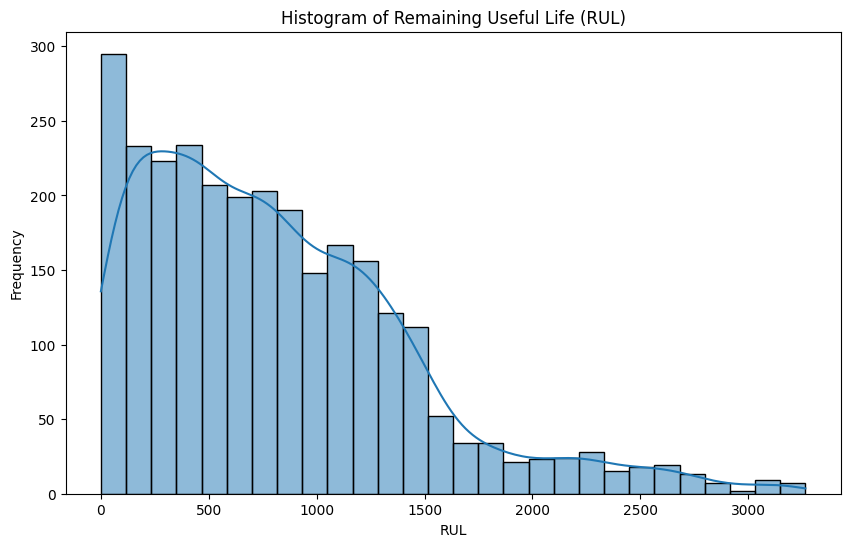

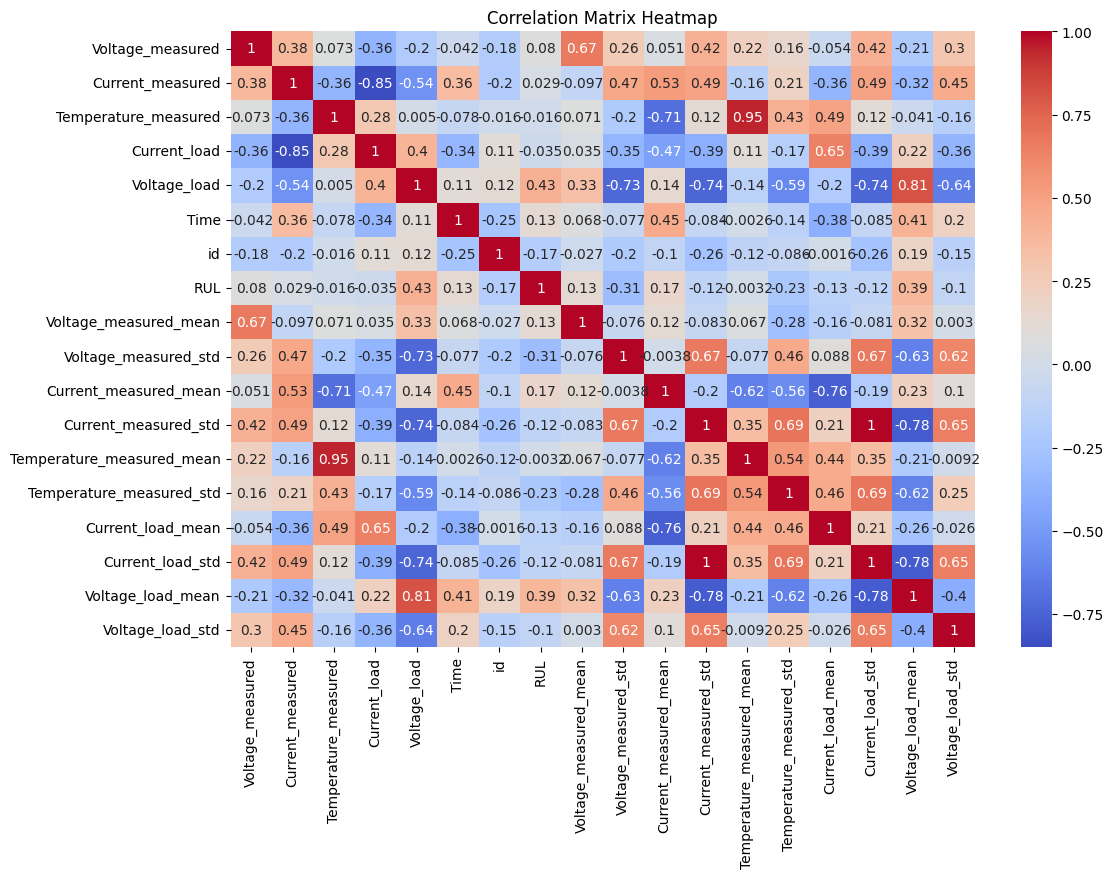

In [7]:
# Histogram of RUL
plt.figure(figsize=(10, 6))
sns.histplot(discharge_df['RUL'], kde=True)
plt.title('Histogram of Remaining Useful Life (RUL)')
plt.xlabel('RUL')
plt.ylabel('Frequency')
plt.show()

# Correlation Matrix Heatmap
correlation_matrix = discharge_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()


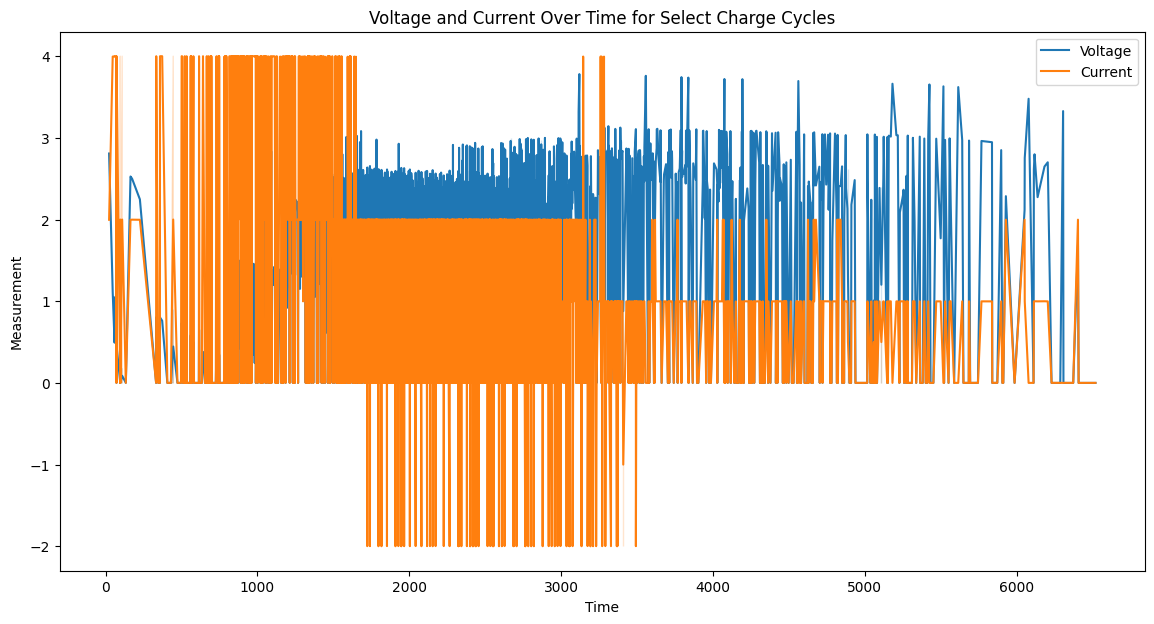

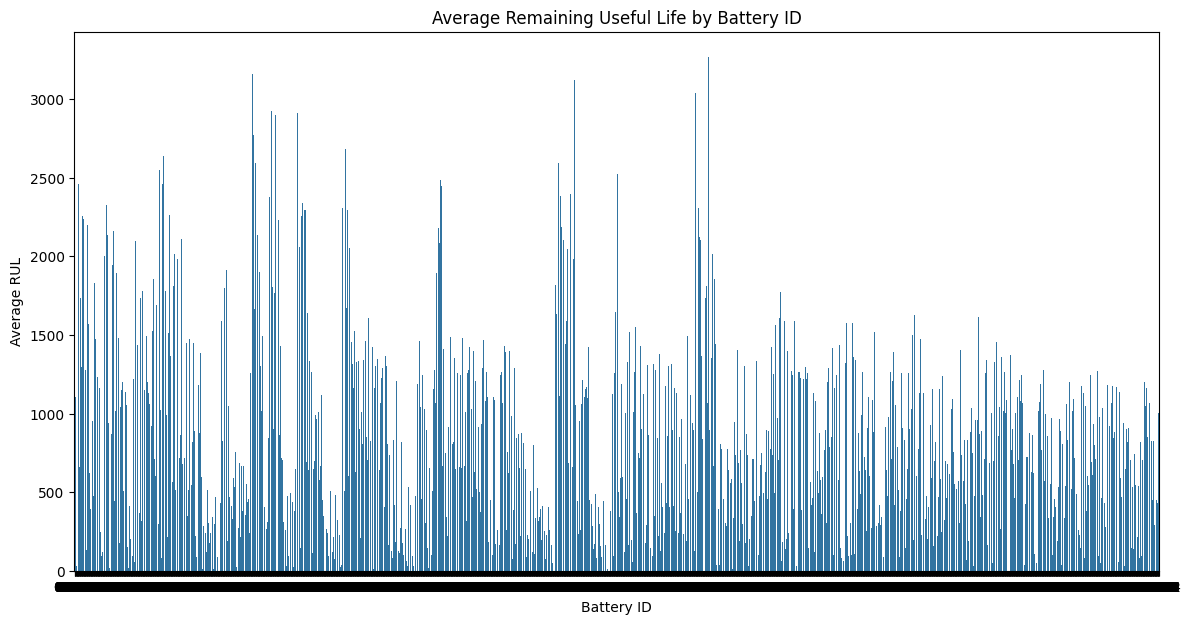

In [14]:
# Assuming df is your DataFrame

# Visualization 1: Line Plot of Voltage and Current Over Time for Select Cycles
# (Assuming 'time' is in a format that allows direct plotting)
plt.figure(figsize=(14, 7))
sns.lineplot(x='Time', y='Voltage_load', data=discharge_df, label='Voltage')
sns.lineplot(x='Time', y='Current_load', data=discharge_df, label='Current')
plt.title('Voltage and Current Over Time for Select Charge Cycles')
plt.xlabel('Time')
plt.ylabel('Measurement')
plt.legend()
plt.show()

# Visualization 2: Scatter Plot of Capacity vs. RUL
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='Capacity', y='RUL', data=charge_df)
# plt.title('Scatter Plot of Capacity vs. Remaining Useful Life')
# plt.xlabel('Capacity')
# plt.ylabel('RUL')
# plt.show()

# Visualization 3: Bar Plot of Average RUL by Battery ID
average_rul_by_battery = discharge_df.groupby('id')['RUL'].mean().reset_index()
plt.figure(figsize=(14, 7))
sns.barplot(x='id', y='RUL', data=average_rul_by_battery)
plt.title('Average Remaining Useful Life by Battery ID')
plt.xlabel('Battery ID')
plt.ylabel('Average RUL')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'meta_data' is your dataframe and it's already loaded
# Generate hypothetical RUL data
np.random.seed(0)
meta_data['RUL'] = np.random.randint(100, 1000, size=len(meta_data))

# Generate hypothetical data for the features, as they were not present in the provided dataframe
meta_data['mean_Voltage_load'] = np.random.uniform(2, 4.2, size=len(meta_data))
meta_data['mean_Temperature_measured'] = np.random.uniform(20, 40, size=len(meta_data))

# Define the top features for plotting
top_features = ["mean_Voltage_load", "mean_Temperature_measured"]

# Filter the dataset for 'discharge' type only
discharge_data = meta_data[meta_data['type'] == 'discharge']

# Iterate over each battery_id to create separate plots
for battery_id in discharge_data['battery_id'].unique():
    # Creating a figure for each battery
    fig, axs = plt.subplots(len(top_features), figsize=(8, 10))
    
    # Extract data for the current battery_id
    battery_data = discharge_data[discharge_data['battery_id'] == battery_id]
    
    for i, feature in enumerate(top_features):
        axs[i].scatter(battery_data[feature], battery_data['RUL'], alpha=0.5)
        axs[i].set_title(f'{battery_id}: RUL vs {feature}')
        axs[i].set_xlabel(f'{feature}')
        axs[i].set_ylabel('RUL')

    plt.tight_layout()
    plt.show()


In [46]:
import pandas as pd

# Load the metadata file

# Convert the 'Capacity' column to numeric, just in case it's not already
meta_data['Capacity'] = pd.to_numeric(meta_data['Capacity'], errors='coerce')

# Select the rows where the capacity first drops below 1.4 Ah
first_below_threshold = meta_data[meta_data['Capacity'] < 1.4].sort_values(by=['battery_id', 'test_id']).drop_duplicates(subset='battery_id', keep='first')

# Calculate the average number of cycles to the first occurrence of RUL = 0
average_cycles_to_first_EOL = first_below_threshold['test_id'].mean()

print(average_cycles_to_first_EOL)


46.96153846153846


In [9]:
discharge_train, discharge_test = train_test_split(discharge_df, test_size=0.2, random_state=42)

drop_cols = ['RUL', 'id']

discharge_train_y = discharge_train['RUL']
discharge_train_X = discharge_train.drop(drop_cols, axis=1)

discharge_test_y = discharge_test['RUL']
discharge_test_X = discharge_test.drop(drop_cols, axis=1)

In [10]:
# Define the selected features based on importance
selected_features = [
    'Voltage_load', 'Time', 'Voltage_load_mean', 
    'Temperature_measured', 'Voltage_measured_mean', 
    'Voltage_measured', 'Voltage_load_std', 'Temperature_measured_std'
]

# Filter the training and testing sets to include only the selected features
discharge_train_X_selected = discharge_train_X[selected_features]
discharge_test_X_selected = discharge_test_X[selected_features]

# Continue with training the model using only the selected features
charge_rf_model = RandomForestRegressor(random_state=0)
charge_rf_model.fit(discharge_train_X_selected, discharge_train_y)

# Predict and evaluate with the selected features
discharge_rf_preds = charge_rf_model.predict(discharge_test_X_selected)
discharge_rf_mae = mean_absolute_error(discharge_test_y, discharge_rf_preds)
discharge_rf_r2 = r2_score(discharge_test_y, discharge_rf_preds)

print(f"Selected Features MAE: {discharge_rf_mae}")
print(f"Selected Features R2S: {discharge_rf_r2}")

Selected Features MAE: 80.59603457960641
Selected Features R2S: 0.9410393108259908


# Random Forest Model

MAE: 77.22569701252239
R2S: 0.9479956041979883
Feature ranking:
Voltage_load: 0.38006781915842747
Time: 0.1261914961499749
Voltage_load_mean: 0.12455559925927019
Temperature_measured: 0.06562994419184319
Voltage_measured: 0.047248733398270966
Voltage_measured_mean: 0.035524515675505255
Current_load_std: 0.0336955496605296
Voltage_load_std: 0.03320845241860972
Current_measured_std: 0.03227115975024342
Voltage_measured_std: 0.026566644292119
Temperature_measured_std: 0.025438176066328425
Temperature_measured_mean: 0.01768570681976879
Current_measured_mean: 0.013905348692721944
Current_load_mean: 0.013875604879709848
Current_load: 0.013021245180268625
Current_measured: 0.01111400440640868


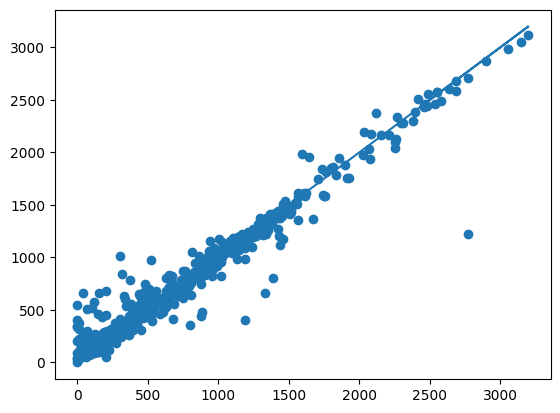

In [47]:
discharge_rf_model = RandomForestRegressor(random_state=355)
discharge_rf_model.fit(discharge_train_X, discharge_train_y)

discharge_rf_preds = discharge_rf_model.predict(discharge_test_X)
discharge_rf_mae = mean_absolute_error(discharge_test_y, discharge_rf_preds)
discharge_rf_r2 = r2_score(discharge_test_y, discharge_rf_preds)
print(f"MAE: {discharge_rf_mae}")
print(f"R2S: {discharge_rf_r2}")

# get feature importance
discharge_rf_importances = discharge_rf_model.feature_importances_
discharge_rf_indices = np.argsort(discharge_rf_importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(discharge_train_X.shape[1]):
    print(f"{discharge_train_X.columns[discharge_rf_indices[f]]}: {discharge_rf_importances[discharge_rf_indices[f]]}")

# plot test_y, preds
plt.scatter(discharge_test_y, discharge_rf_preds)
plt.plot(discharge_test_y, discharge_test_y)
plt.savefig("rul_nasa.png")

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

# Assuming discharge_train_X and discharge_train_y are your features and target variable respectively
discharge_rf_model = RandomForestRegressor(random_state=355)

# Perform 5-fold cross-validation
scores = cross_val_score(discharge_rf_model, discharge_train_X, discharge_train_y, cv=10, scoring='neg_mean_absolute_error')

# Perform 5-fold cross-validation and calculate R squared metric
r2_scores = cross_val_score(discharge_rf_model, discharge_train_X, discharge_train_y, cv=10, scoring='r2')

# Print the R squared scores for each fold
print("R squared scores for each fold:", r2_scores)

# Calculate and print the mean R squared score across all folds
print("Mean R squared score:", r2_scores.mean())

# Convert scores to positive. cross_val_score returns negative values for MAE and MSE as these are "losses" that the function tries to minimize
mae_scores = -scores

print(f"MAE scores for each fold are: {mae_scores}")
print(f"Average MAE across all folds: {np.mean(mae_scores)}")
print(f"Standard deviation of MAE across all folds: {np.std(mae_scores)}")


R squared scores for each fold: [0.93659533 0.93412327 0.95567956 0.90977826 0.94033692 0.92122197
 0.89163027 0.92318709 0.91813028 0.95871517]
Mean R squared score: 0.9289398122687725
MAE scores for each fold are: [79.64602058 91.41288687 82.18707973 98.45491915 83.66787616 83.27710623
 90.40299605 89.85855072 93.49844888 76.58758018]
Average MAE across all folds: 86.89934645627798
Standard deviation of MAE across all folds: 6.505348974306966


# XGB Model

MAE: 91.35008605871477
R2S: 0.9365608081599761
Feature ranking:
Voltage_load: 0.4533855617046356
Voltage_load_mean: 0.10086704045534134
Time: 0.07914027571678162
Current_measured_std: 0.07478506863117218
Current_load_std: 0.05836888402700424
Voltage_load_std: 0.04856527969241142
Temperature_measured: 0.040193550288677216
Current_load: 0.029581470414996147
Temperature_measured_std: 0.027751373127102852
Temperature_measured_mean: 0.019257038831710815
Voltage_measured_mean: 0.01780015230178833
Voltage_measured: 0.012861697934567928
Current_measured_mean: 0.010673098266124725
Voltage_measured_std: 0.010159056633710861
Current_measured: 0.008467183448374271
Current_load_mean: 0.0081432294100523


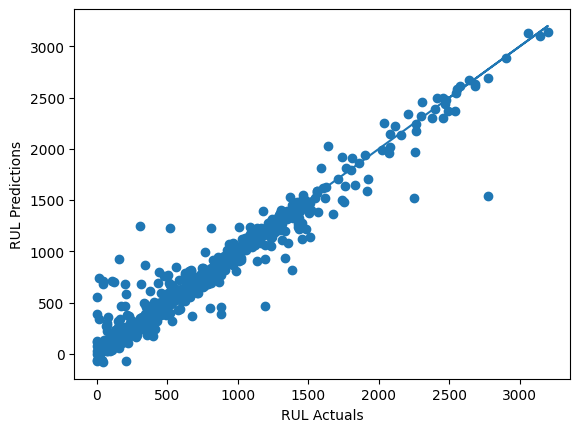

In [62]:
discharge_xgb_model = xgb.XGBRegressor(random_state=355)
discharge_xgb_model.fit(discharge_train_X, discharge_train_y)

discharge_xgb_preds = discharge_xgb_model.predict(discharge_test_X)
discharge_xgb_mae = mean_absolute_error(discharge_test_y, discharge_xgb_preds)
discharge_xgb_r2 = r2_score(discharge_test_y, discharge_xgb_preds)
print(f"MAE: {discharge_xgb_mae}")
print(f"R2S: {discharge_xgb_r2}")

# get feature importance
discharge_xgb_importances = discharge_xgb_model.feature_importances_
discharge_xgb_indices = np.argsort(discharge_xgb_importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(discharge_train_X.shape[1]):
    print(f"{discharge_train_X.columns[discharge_xgb_indices[f]]}: {discharge_xgb_importances[discharge_xgb_indices[f]]}")

# plot test_y, preds
plt.scatter(discharge_test_y, discharge_xgb_preds)
plt.plot(discharge_test_y, discharge_test_y)
plt.xlabel('RUL Actuals')
plt.ylabel('RUL Predictions')
plt.savefig("rul_nasa.png")

In [54]:
# Perform 5-fold cross-validation and compute the R2 score
cv_r2_scores_xgb = cross_val_score(discharge_xgb_model, discharge_train_X, discharge_train_y, cv=10, scoring='r2')
# Perform 5-fold cross-validation and compute the negative MAE
cv_mae_scores_xgb = cross_val_score(discharge_xgb_model, discharge_train_X, discharge_train_y, cv=10, scoring='neg_mean_absolute_error')

# Negate the scores to get positive MAE values
cv_mae_scores_xgb = -cv_mae_scores_xgb


print("Cross-Validation R2 scores for XGB model:", cv_r2_scores_xgb)
print("Mean CV R2 score for XGB model:", cv_r2_scores_xgb.mean())
print("Cross-Validation MAE scores for XGB model:", cv_mae_scores_xgb)
print("Mean CV MAE score for XGB model:", cv_mae_scores_xgb.mean())


Cross-Validation R2 scores for XGB model: [0.9418016  0.93723345 0.94641154 0.92794947 0.91843978 0.91931345
 0.92199096 0.91755229 0.93522627 0.96458417]
Mean CV R2 score for XGB model: 0.9330502989170542
Cross-Validation MAE scores for XGB model: [78.48483826 88.35498354 93.46488016 91.69585062 99.22866769 96.37856691
 85.92611432 94.72437697 95.1554843  76.11474288]
Mean CV MAE score for XGB model: 89.95285056587781


### LGBM Model

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3858
[LightGBM] [Info] Number of data points in the train set: 2235, number of used features: 16
[LightGBM] [Info] Start training from score 809.840916
MAE: 86.88017457516817
R2S: 0.9426340251514083
Feature ranking:
Time: 489
Voltage_load_mean: 234
Voltage_measured_std: 229
Voltage_measured_mean: 214
Temperature_measured_mean: 207
Voltage_load: 206
Voltage_measured: 199
Temperature_measured: 197
Voltage_load_std: 171
Current_measured_mean: 156
Current_measured: 139
Temperature_measured_std: 126
Current_load: 126
Current_measured_std: 121
Current_load_std: 97
Current_load_mean: 89


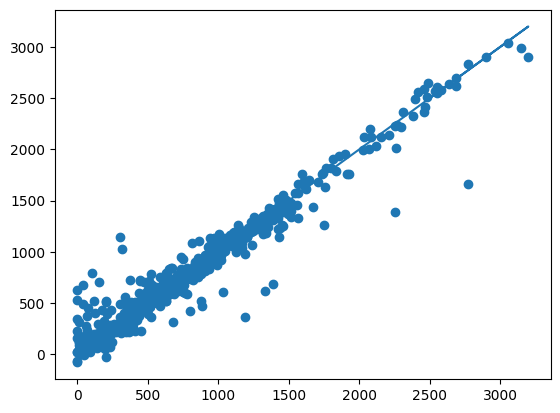

In [60]:
import lightgbm

discharge_lgb_model = lightgbm.LGBMRegressor(random_state=355)
discharge_lgb_model.fit(discharge_train_X, discharge_train_y)

discharge_lgb_preds = discharge_lgb_model.predict(discharge_test_X)
discharge_lgb_mae = mean_absolute_error(discharge_test_y, discharge_lgb_preds)
discharge_lgb_r2 = r2_score(discharge_test_y, discharge_lgb_preds)
print(f"MAE: {discharge_lgb_mae}")
print(f"R2S: {discharge_lgb_r2}")

# get feature importance
charge_lgb_importances = discharge_lgb_model.feature_importances_
charge_lgb_indices = np.argsort(charge_lgb_importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(discharge_train_X.shape[1]):
    print(f"{discharge_train_X.columns[charge_lgb_indices[f]]}: {charge_lgb_importances[charge_lgb_indices[f]]}")

# plot test_y, preds
plt.scatter(discharge_test_y, discharge_lgb_preds)
plt.plot(discharge_test_y, discharge_test_y)
plt.savefig("rul_nasa.png")

In [61]:
# R-squared scores
cv_r2_scores_lgb = cross_val_score(discharge_lgb_model, discharge_train_X, discharge_train_y, cv=5, scoring='r2')
# MAE scores
cv_mae_scores_lgb = cross_val_score(discharge_lgb_model, discharge_train_X, discharge_train_y, cv=5, scoring='neg_mean_absolute_error')
cv_mae_scores_lgb = -cv_mae_scores_lgb  # Convert to positive MAE scores

print("Cross-Validation R2 scores for LGBM model:", cv_r2_scores_lgb)
print("Mean CV R2 score for LGBM model:", cv_r2_scores_lgb.mean())
print("Cross-Validation MAE scores for LGBM model:", cv_mae_scores_lgb)
print("Mean CV MAE score for LGBM model:", cv_mae_scores_lgb.mean())

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3857
[LightGBM] [Info] Number of data points in the train set: 1788, number of used features: 16
[LightGBM] [Info] Start training from score 805.950218
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3856
[LightGBM] [Info] Number of data points in the train set: 1788, number of used features: 16
[LightGBM] [Info] Start training from score 804.607329
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3857
[LightGBM] [Info] Number of data points in the train set: 1788, number of used features: 16
[LightGBM] [Info] Start tr